Looking at Amazon's robots.txt file (or Twitter's, or Facebook's), you may be surprised to see them prohibit or severely restrict scraping.  Aren't there a lot of projects online using Twitter data?  And how dare they keep all that delicious, delicious information to themselves?  But before you start setting `'ROBOTSTXT_OBEY' = False`, read on!

Most of The Big Websites (Google, Facebook, Twitter, etc) have APIs that allow you to access their information programmatically without using webpages.  This is good for both you and the website.  With an API, you can ask the server to send you only the specific information you want, without having to retrieve, filter out, and discard the CSS, HTML, PHP, and other code from the website.  This minimizes demand on the server and speeds up your task.  

APIs typically include their own throttling to keep you from overloading the server, usually done by limiting the number of server requests per hour to a certain number.  

To access an API, you will usually need an API key or token that uniquely identifies you.  This lets the company or service providing the API keep an eye on your usage and track what you are doing.  Different API keys can also be associated with different levels of authorization and access, so they work as a data security measure.  Keys or tokens may also be set to expire after a certain amount of time or number of uses.

## Anatomy of an API

*Access*- You request a key.  Your program provides the key with each API call, and it determines what your program can do in the API.  
*Requests*- Your program requests the data you want with a call to the API.  The request will be made up of a method (type of query, using language defined by the API) and parameters (refine the query).  
*Response*- The data returned by the API, usually in a common format such as JSON that your program can parse.  

The specific syntax for each of these elements, and the format of the response, will vary from API to API.  In addition, APIs vary widely in their level of documentation and ease of use.  Before diving too deeply into an API-scraping project, do some judicious googling and if you see a lot of posts [like this one](https://mollyrocket.com/casey/stream_0029.html) consider going elsewhere.  Not all websites put their APIs front-and-center (did you know there are APIs for [NASA](https://api.nasa.gov/), [Marvel Comics](http://developer.marvel.com/), and [Star Wars](https://swapi.co/)?) so google will be your friend there as well.

## Basics of API Queries: Wikipedia's API

The process of using an API sounds a lot like scraping (make request, get response), but with an occasional added authorization layer.  Scrapy can handle authorization, so we can use it to access APIs too.

That said, the first API we'll pull from is [Wikipedia's](https://www.mediawiki.org/wiki/API:Main_page), which doesn't require an authorization key.  Aside from needing to master the API's language, you'll find that using scrapy with an API is very similar to using scrapy on a website.

We want to know what other entries on Wikipedia link to the [Monty Python](https://en.wikipedia.org/wiki/Monty_Python) page.  To do this, we can build a query using the [Wikipedia API Sandbox](https://en.wikipedia.org/wiki/Special:ApiSandbox).  Someone who is comfortable with the MediaWiki API syntax wouldn't need to use the sandbox, but for beginners it is very handy.  Note that API queries are nothing like SQL queries in syntax, despite their shared name.

The query we will use looks like this:
`https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect`

Let's break that down into it's components:

* `w/api.php`
    * Tells the server that we are using the API to pull info, rather than scraping the raw pages.  
    
* `action=query`   
    * We want information from the API (as opposed to changing information in the API)  
    
* `format=xml`  
    * Format the return in xml- then we will parse it with xpath  
    
* `prop=linkshere`  
    * We are interested in which pages link to our target page 
    
* `titles=Monty_Python`  
    * The target page is the Monty Python page.  Note that we used the exact name of the wikipedia page (Monty_Python).  
    
* `lhprop=title`  
    * From those links, we want the title of each page  
    
* `redirect`  
    * We also want to know if that link is a redirect  
    

The syntax of the MediaWiki API is based on php, thus the inclusion of `?` and `&` in the query.

For most of the query elements, we could have passed multiple arguments.  For example, we could request the URL as well as the title of the linking pages, or asked for all the pages that link to Monty_Python and to Monty_Python's_Flying_Circus.  

A query like this highlights why APIs are so handy.  Without an API, to find out the name of every page on Wikipedia that links to the Monty Python page we would have to scrape every single one of the 5,000,000+ articles in the English-language Wikipedia.  

If you haven't done so already, click on the query link above and see what it returns.



## Why use Scrapy for API calls

For some API calls, scrapy would be overkill.  If you know that your query can be answered in one response, then you don't need scrapy- you can use the `requests` library to make your API call and a library like `lxml` to parse the return.

The Wikipedia API, however, will only return ten items at a time in response to a query.  This sort of limitation is common to APIs to avoid overwhelming the server.  We can use scrapy to iterate over query results the same way that we iterated over the pages of the EverydaySexism website. 

Let's see the Wikipedia API and scrapy in action:



In [1]:
import scrapy
from scrapy.crawler import CrawlerProcess


class WikiSpider(scrapy.Spider):
    name = "WS"
    
    # Here is where we insert our API call.
    start_urls = [
        'https://en.wikipedia.org/w/api.php?action=query&format=xml&prop=linkshere&titles=Monty_Python&lhprop=title%7Credirect'
        ]

    # Identifying the information we want from the query response and extracting it using xpath.
    def parse(self, response):
        for item in response.xpath('//lh'):
            # The ns code identifies the type of page the link comes from.  '0' means it is a Wikipedia entry.
            # Other codes indicate links from 'Talk' pages, etc.  Since we are only interested in entries, we filter:
            if item.xpath('@ns').extract_first() == '0':
                yield {
                    'title': item.xpath('@title').extract_first() 
                    }
        # Getting the information needed to continue to the next ten entries.
        next_page = response.xpath('continue/@lhcontinue').extract_first()
        
        # Recursively calling the spider to process the next ten entries, if they exist.
        if next_page is not None:
            next_page = '{}&lhcontinue={}'.format(self.start_urls[0],next_page)
            yield scrapy.Request(next_page, callback=self.parse)
            
    
process = CrawlerProcess({
    'FEED_FORMAT': 'json',
    'FEED_URI': 'PythonLinks.json',
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 10
})
                                         

# Starting the crawler with our spider.
process.crawl(WikiSpider)
process.start()
print('First 100 links extracted!')

First 100 links extracted!


In [2]:
import pandas as pd

# Checking whether we got data 

Monty=pd.read_json('PythonLinks.json', orient='records')
print(Monty.shape)
print(Monty.tail())

(92, 1)
                         title
87           Catherine Deneuve
88           Beyond the Fringe
89                        Cunt
90        List of Welsh people
91  Downing College, Cambridge


## Wrap up

Our API call was successful.  While we examined 100 links, we only saved 92 (the others weren't links from entry pages).  

We've barely scraped (pun intended) the surface of what scrapy and APIs can do.  Scrapy has changed a lot in the years since its debut, so when googling make sure the answers you see are from 2015 at the latest-- otherwise you'll likely not be able to use the code.  

Back to the issue of authorization keys- often the key is simply included in the query string as an additional arguments.  In other cases, if you need your scraper to be able to enter a key or login information into a form, scrapy [has you covered](http://stackoverflow.com/questions/30102199/form-authentication-login-a-site-using-scrapy).  

There's a lot of fun to be had in scraping and APIs-- it's a way to feel like you're getting a lot of information with very little effort!  Beware, however.  You're not getting information at all.  Scraping gives you *data*, an undifferentiated mess of bytes with no compelling meaning on its own.  Think of that list of Wiki entries that link to Monty Python.  It's cool that we could get it, but what does it mean?  Your job as a data scientist is to convert *data* to *information*-- something people can use to make decisions or understand the world.  Modeling data to get information is hard but worthwhile work, and its those kinds of projects that will really build your portfolio as you go on the market.  

That said, scraping up some original data can provide the *foundation* for an interesting and original final project.

## Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

In [ ]:
import pandas as pd
import numpy as np

#import scrapy
import scrapy
import re
from scrapy.crawler import CrawlerProcess


# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib import gridspec
import descartes
from matplotlib import cm
%matplotlib inline

import scipy.stats as stats
from scipy.stats import norm, skew #for some statistics

import nltk
import itertools

from sklearn.metrics import confusion_matrix
from sklearn import linear_model

# importing stopwords 
from nltk.corpus import stopwords
stop = stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import time
from datetime import datetime

### Create API with scrapy

The website chosen was from a tutorial that referenced famous authors.
2 scrapers were created
- quotes
- author bio information

Of course, we will need to restart the kernel after the first API is executed.

In [1]:
class QuotesSpider(scrapy.Spider):
    name = "quotes"
    start_urls = [
        'http://quotes.toscrape.com/page/1/',
    ]

    def parse(self, response):
        for quote in response.css('div.quote'):
            yield {
                'text': quote.css('span.text::text').get(),
                'author': quote.css('span small::text').get(),
                'tags': quote.css('div.tags a.tag::text').getall(),
            }

        next_page = response.css('li.next a::attr(href)').get()
        
        # There are a LOT of pages here.  For our example, we'll just scrape the first 9.
        # This finds the page number. The next segment of code prevents us from going beyond page 9.
        pagenum = int(re.findall(r'\d+',next_page)[0])
        
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None:
            #next_page = response.follow(next_page, callback=self.parse)
            # Request the next page and recursively parse it the same way we did above
            yield response.follow(next_page, callback=self.parse)
            
# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.  
process = CrawlerProcess({
    'FEED_FORMAT': 'json',          # Store data in JSON format.
    'FEED_URI': 'quotes.json',  # Name our storage file.
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,          # Turn off logging for now.
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 40
})

# Starting the crawler with our spider.
process.crawl(QuotesSpider)
process.start()
print('DONE!!')

First 100 links extracted!


Don't forget to restart the kernel!

The second API will access the quotes.

In [1]:
import scrapy
import re
from scrapy.crawler import CrawlerProcess


class AuthorSpider(scrapy.Spider):
    name = 'author'

    start_urls = ['http://quotes.toscrape.com/']

    def parse(self, response):
        author_page_links = response.css('.author + a')
        yield from response.follow_all(author_page_links, self.parse_author)

        pagination_links = response.css('li.next a')
        yield from response.follow_all(pagination_links, self.parse)

    def parse_author(self, response):
        def extract_with_css(query):
            return response.css(query).get(default='').strip()

        yield {
            'name': extract_with_css('h3.author-title::text'),
            'birthdate': extract_with_css('.author-born-date::text'),
            'bio': extract_with_css('.author-description::text'),
        }
        
# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.  
process = CrawlerProcess({
    'FEED_FORMAT': 'json',          # Store data in JSON format.
    'FEED_URI': 'AuthorBios.json',  # Name our storage file.
    # Note that because we are doing API queries, the robots.txt file doesn't apply to us.
    'ROBOTSTXT_OBEY': False,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True,
    'LOG_ENABLED': False,          # Turn off logging for now.
    # We use CLOSESPIDER_PAGECOUNT to limit our scraper to the first 100 links.    
    'CLOSESPIDER_PAGECOUNT' : 40
})

# Starting the crawler with our spider.
process.crawl(AuthorSpider)
process.start()
print('DONE!!')

First 100 links extracted!


### Reading JSON Files

In [4]:
import pandas as pd

# Checking whether we got data from all 9 pages
df_quotes=pd.read_json('quotes.json', orient='records')
print(df_quotes.shape)
print(df_quotes.head())

(100, 3)
                                                text           author  \
0  “The world as we have created it is a process ...  Albert Einstein   
1  “It is our choices, Harry, that show what we t...     J.K. Rowling   
2  “There are only two ways to live your life. On...  Albert Einstein   
3  “The person, be it gentleman or lady, who has ...      Jane Austen   
4  “Imperfection is beauty, madness is genius and...   Marilyn Monroe   

                                             tags  
0        [change, deep-thoughts, thinking, world]  
1                            [abilities, choices]  
2  [inspirational, life, live, miracle, miracles]  
3              [aliteracy, books, classic, humor]  
4                    [be-yourself, inspirational]  


In [2]:
# Checking whether we got data from all 9 pages
df_bios=pd.read_json('AuthorBios.json', orient='records')
print(df_bios.shape)
print(df_bios.head())

(33, 3)
                name          birthdate  \
0       J.K. Rowling      July 31, 1965   
1    Albert Einstein     March 14, 1879   
2       Steve Martin    August 14, 1945   
3  Eleanor Roosevelt   October 11, 1884   
4   Thomas A. Edison  February 11, 1847   

                                                 bio  
0  See also: Robert GalbraithAlthough she writes ...  
1  In 1879, Albert Einstein was born in Ulm, Germ...  
2  Stephen Glenn "Steve" Martin is an American ac...  
3  Anna Eleanor Roosevelt was an American politic...  
4  Thomas Alva Edison was an American inventor, s...  


Both dataframes seem to be in good shape. Let's merge them together to a single dataframe.<br>
Take note that the column name for the authors are different. <br>
Easiest path here is to simply make the column names the same. 

In [8]:
# change column name from 'name' to 'author'
df_bios = df_bios.rename(columns={'name': 'author'})
df_bios.head()

,author,birthdate,bio
0,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...
1,Albert Einstein,"March 14, 1879","In 1879, Albert Einstein was born in Ulm, Germ..."
2,Steve Martin,"August 14, 1945","Stephen Glenn ""Steve"" Martin is an American ac..."
3,Eleanor Roosevelt,"October 11, 1884",Anna Eleanor Roosevelt was an American politic...
4,Thomas A. Edison,"February 11, 1847","Thomas Alva Edison was an American inventor, s..."


In [140]:
# merging dataframes on author
df_merged = pd.merge(df_bios, df_quotes, on='author')

### Data Exploration

In [141]:
df_merged.sample(5)

,author,birthdate,bio,text,tags
22,Thomas A. Edison,"February 11, 1847","Thomas Alva Edison was an American inventor, s...","“I have not failed. I've just found 10,000 way...","[edison, failure, inspirational, paraphrased]"
69,C.S. Lewis,"November 29, 1898",CLIVE STAPLES LEWIS (1898–1963) was one of the...,“To love at all is to be vulnerable. Love anyt...,[love]
8,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,"“The truth."" Dumbledore sighed. ""It is a beaut...",[truth]
65,Charles M. Schulz,"November 26, 1922",Charles Monroe Schulz was an American cartooni...,“All you need is love. But a little chocolate ...,"[chocolate, food, humor]"
24,Marilyn Monroe,"June 01, 1926",Marilyn Monroe (born Norma Jeane Mortenson; Ju...,"“Imperfection is beauty, madness is genius and...","[be-yourself, inspirational]"


In [142]:
df_merged.describe()

,author,birthdate,bio,text,tags
count,81,81,81,81,81
unique,33,33,33,81,70
top,Albert Einstein,"March 14, 1879","In 1879, Albert Einstein was born in Ulm, Germ...",“Not all of us can do great things. But we can...,[love]
freq,10,10,10,1,4


In [143]:
df_merged.author.value_counts()

Albert Einstein           10
J.K. Rowling               9
Marilyn Monroe             7
Dr. Seuss                  6
Mark Twain                 6
Jane Austen                5
C.S. Lewis                 5
Bob Marley                 3
Ralph Waldo Emerson        2
Mother Teresa              2
Eleanor Roosevelt          2
George R.R. Martin         2
Ernest Hemingway           2
Stephenie Meyer            1
Friedrich Nietzsche        1
Thomas A. Edison           1
Haruki Murakami            1
Allen Saunders             1
James Baldwin              1
Steve Martin               1
Pablo Neruda               1
Charles M. Schulz          1
Jorge Luis Borges          1
Helen Keller               1
George Eliot               1
Martin Luther King Jr.     1
Elie Wiesel                1
André Gide                 1
George Bernard Shaw        1
Douglas Adams              1
William Nicholson          1
Garrison Keillor           1
Jim Henson                 1
Name: author, dtype: int64

In [144]:
df_merged.tags.value_counts()

[love]                                                       4
[attributed-no-source]                                       3
[inspirational]                                              3
[dumbledore]                                                 2
[truth]                                                      2
                                                            ..
[friends, heartbreak, inspirational, life, love, sisters]    1
[books, classic, reading]                                    1
[books, mind]                                                1
[inspirational, life, live, miracle, miracles]               1
[books, library]                                             1
Name: tags, Length: 70, dtype: int64

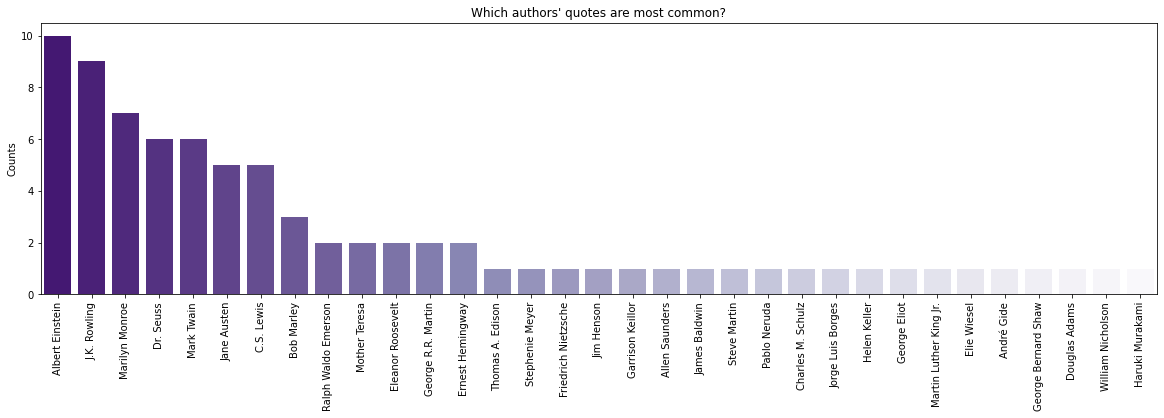

In [145]:
description_counts = df_merged.author.value_counts().sort_values(ascending=False)
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which authors' quotes are most common?");
plt.xticks(rotation=90);

Albert Einstein and J.K. Rowling are 2 of the most abundantly quoted authors in this dataset. Keep in mind that this data does not really represent the factual occurance of quote frequency and there's zero context as to how these quotes are used.

That all being said, looking at the dataframe, there can be some clean up methods applied to make the data easier to understand and analyze.

### Feature Engineering

In [146]:
# changing text to quote for user context
df_merged = df_merged.rename(columns={'text': 'quote'})

In [147]:
# create new column that converts the dtype in 'tags' from a list to strings
df_merged['TagString'] = [' '.join(map(str, l)) for l in df_merged['tags']]
df_merged.head()

,author,birthdate,bio,quote,tags,TagString
0,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,"“It is our choices, Harry, that show what we t...","[abilities, choices]",abilities choices
1,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,“It takes a great deal of bravery to stand up ...,"[courage, friends]",courage friends
2,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,“It is impossible to live without failing at s...,[],
3,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,"“Of course it is happening inside your head, H...",[dumbledore],dumbledore
4,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,"“To the well-organized mind, death is but the ...","[death, inspirational]",death inspirational


In [148]:
# looking at frequency of words in the column to see if anything stands out
df_merged.TagString.str.split(expand=True).stack().value_counts()

love             12
inspirational    12
life             11
books             9
humor             7
                 ..
wisdom            1
deep-thoughts     1
lack-of-love      1
opposite          1
plans             1
Length: 108, dtype: int64

In [149]:
# there are blanks after converting dtypes. 
# let's replace those with nans or else they might get counted as entries later.
df_merged.TagString = df_merged.TagString.replace(r'^\s*$', np.nan, regex=True)

In [150]:
# Counting words in customer_comments_lwr_case
df_merged['TagCount'] = df_merged['TagString'].str.split(" ").str.len()

In [151]:
# filling nans with 0 in the numeric column
df_merged['TagCount'] = df_merged['TagCount'].fillna(0)

In [152]:
df_merged.groupby('author')['TagCount'].sum().sort_values(ascending = False)

author
Albert Einstein           25.0
Jane Austen               15.0
Mark Twain                14.0
Marilyn Monroe            13.0
C.S. Lewis                13.0
J.K. Rowling              11.0
Dr. Seuss                 11.0
Elie Wiesel                8.0
Friedrich Nietzsche        6.0
George R.R. Martin         6.0
Allen Saunders             5.0
Ernest Hemingway           5.0
Thomas A. Edison           4.0
Eleanor Roosevelt          4.0
Bob Marley                 3.0
Steve Martin               3.0
Charles M. Schulz          3.0
Mother Teresa              3.0
Stephenie Meyer            3.0
Ralph Waldo Emerson        3.0
George Bernard Shaw        3.0
Douglas Adams              2.0
André Gide                 2.0
William Nicholson          2.0
Garrison Keillor           2.0
Jorge Luis Borges          2.0
Martin Luther King Jr.     2.0
Pablo Neruda               2.0
Haruki Murakami            2.0
George Eliot               1.0
Helen Keller               1.0
James Baldwin              1.0
J

In [153]:
# new column with lower case
df_merged['QuoteLower'] = df_merged['quote'].str.lower()

In [154]:
# general clean up script that was used in previous exercise. Formats strings to be similar style
spec_chars = ['"', ',', '(', ')', '.', '-','_', '“', '”']

# fewer required characters with for loop vs method chaining
for char in spec_chars:
    df_merged['QuoteLower']  = df_merged['QuoteLower'].str.strip().str.replace(char, ' ')

In [155]:
# remove stop words
df_merged['stop_quote'] = df_merged['QuoteLower'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [156]:
# Counting words in customer_comments_lwr_case
df_merged['StopQuoteCount'] = df_merged['stop_quote'].str.split(" ").str.len()

In [157]:
df_merged.head()

,author,birthdate,bio,quote,tags,TagString,TagCount,QuoteLower,stop_quote,StopQuoteCount
0,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,"“It is our choices, Harry, that show what we t...","[abilities, choices]",abilities choices,2.0,it is our choices harry that show what we tr...,choices harry show truly far abilities,6
1,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,“It takes a great deal of bravery to stand up ...,"[courage, friends]",courage friends,2.0,it takes a great deal of bravery to stand up t...,takes great deal bravery stand enemies much st...,9
2,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,“It is impossible to live without failing at s...,[],NaN,0.0,it is impossible to live without failing at so...,impossible live without failing something unle...,14
3,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,"“Of course it is happening inside your head, H...",[dumbledore],dumbledore,1.0,of course it is happening inside your head ha...,course happening inside head harry earth mean ...,8
4,J.K. Rowling,"July 31, 1965",See also: Robert GalbraithAlthough she writes ...,"“To the well-organized mind, death is but the ...","[death, inspirational]",death inspirational,2.0,to the well organized mind death is but the n...,well organized mind death next great adventure,7


In [160]:
# convert date column to datetime dtype
df_merged.birthdate = pd.to_datetime(df_merged['birthdate'])

# parse datetime column into separate values
df_merged['BirthYear'] = df_merged.birthdate.dt.year
df_merged['BirthMonth'] = df_merged.birthdate.dt.month
df_merged['BirthDay'] = df_merged.birthdate.dt.day

# new column that displays how many years ago the author was born
df_merged['YearsBornAgo'] = datetime.now().year - df_merged['BirthYear']

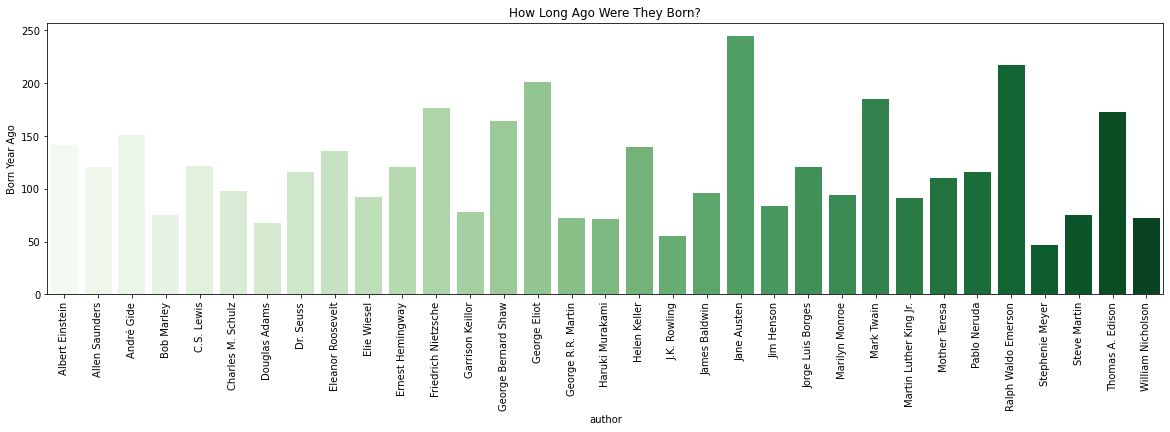

In [243]:
plt.figure(figsize=(20,5))
sns.barplot(df_merged.author, df_merged.YearsBornAgo.values, palette='Greens')
plt.ylabel("Born Year Ago")
plt.title("How Long Ago Were They Born?");
plt.xticks(rotation=90);

In [161]:
# 'TotalTags'

# create new data frame with customerid, revenue, and event
df = df_merged[['author', 'TagCount']].copy()

# pd.Grouper method to create new dataframe from groupby
df = df.groupby(pd.Grouper(key ='author')).sum().reset_index()

# rename columns to better reflect the new features
df = df.rename(columns={'TagCount' :'TotalTags'})

# merge data frames on CustomerID
df_merged = df_merged.merge(df, on = 'author')

In [162]:
# 'TotalQuotes'

# create new data frame with customerid, revenue, and event
df = df_merged[['author', 'TagCount']].copy()

# pd.Grouper method to create new dataframe from groupby
df = df.groupby(pd.Grouper(key ='author')).count().reset_index()

# rename columns to better reflect the new features
df = df.rename(columns={'TagCount' :'TotalQuotes'})

# merge data frames on CustomerID
df_merged = df_merged.merge(df, on = 'author')

In [163]:
# convert author to category then apply cat.codes to get numeric categorical assignment
df_merged["author"] = df_merged["author"].astype('category')
df_merged["AuthorCatCodes"] = df_merged["author"].cat.codes.astype('category')

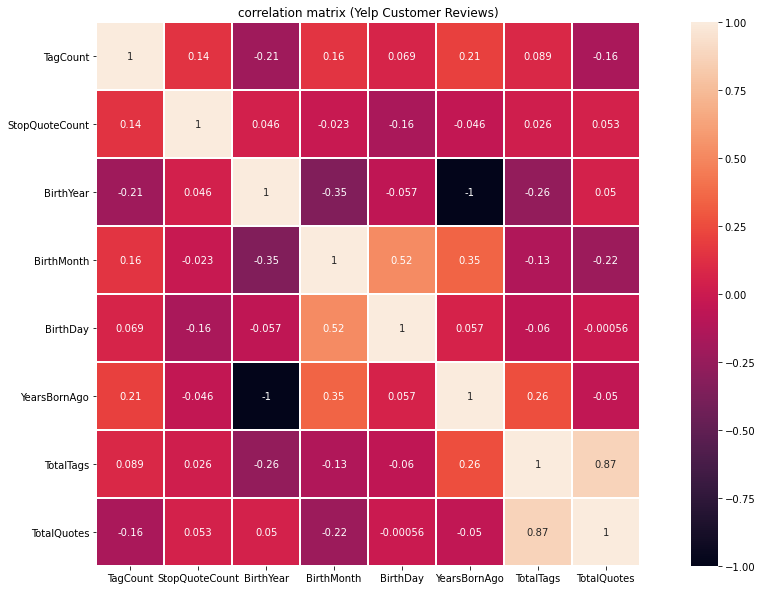

In [165]:
# plot correlation matrix visual
corrmat_life = df_merged.corr()

plt.figure(figsize= (40,10))

plt.subplot(1,2,1)
# draw the heatmap using seaborn.
sns.heatmap(corrmat_life, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Yelp Customer Reviews)")

plt.show()

With exception of dates, TotalTags, and TotalQuotes, the features don't seem to be all that associated with each other. fairly low amount of correlation coef. That's good news if we want to run a model because we might not have too many multicolinear issues.

Which words are used most frequently?

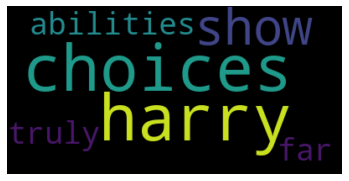

In [181]:
# first line of the dataframe... clearly Harry Potter
text = df_merged.stop_quote[0]

wordcloud = WordCloud(max_words=100).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [175]:
# Run on whole stop_quote column
text = " ".join(review for review in df_merged.stop_quote)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 5677 words in the combination of all review.


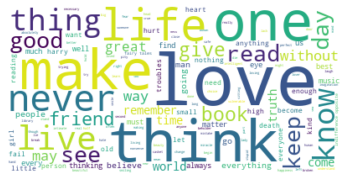

In [176]:
# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The words that pop include love, think, one, life, make, one, live, and keep. 
There are several others to point out but it seems that the general feeling these words could bring to a reader is that of positivity. Inspirational quotes are fairly popular. Let's see what the tag feature looks like.

In [191]:
# TagString
text2 = " ".join(str(review) for review in df_merged.TagString)
print ("There are {} words in the combination of all review.".format(len(text2)))

There are 1670 words in the combination of all review.


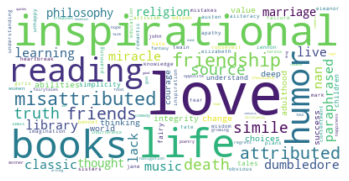

In [190]:
# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text2)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Literally, the word "inspirational" pops out. Again, general positive descriptive words come to the forefront of the graphic. 

### Summary

We applied 2 scrapy APIs and combined 2 dataframes to bring separate data together. 2 APIs were necessary because I'm not an expert and the layout of the web pages were different based on context.

The insight gathered from just a handful of columns include: word frequency and context, relative age of the authors, feature correlation, and the frequency each other was entered into the dataframe.

Generally, more blood could be squeezed out of this turnip but the general scope of this project to was to ensure the APIs worked appropriately enough to generate rough insight into the data. 